## Reproduce DARTFISH results with a Pixel Decoding Method

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from starfish.experiment import Experiment
from starfish.types import Features, Indices

from starfish.codebook import Codebook

from starfish.intensity_table import IntensityTable

from starfish.stack import ImageStack
from starfish.image import Filter
from starfish.spots import SpotFinder

sns.set_context('talk')
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load image stack

Note that the data here corresopond to DARTFISHv1 2017. The group is actively working on improving the protocol.

In [2]:

exp = Experiment.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180905/DARTFISH/experiment.json')
stack = exp.fov().primary_image

# TODO the latter will be fixed by https://github.com/spacetx/starfish/issues/316
stack._data = stack._data.astype(float)

100%|██████████| 1/1 [00:00<00:00, 65.66it/s]


In [3]:
print(stack.shape)

OrderedDict([(<Indices.ROUND: 'r'>, 6), (<Indices.CH: 'c'>, 3), (<Indices.Z: 'z'>, 1), ('y', 988), ('x', 988)])


In [4]:
stack.show_stack({Indices.CH:0}, rescale=True);

Rescaling ...


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


interactive(children=(IntSlider(value=0, description='plane_index', max=5), Output()), _dom_classes=('widget-interact',))

### Load codebook

In [5]:
exp.codebook

<xarray.Codebook (target: 96, c: 3, r: 6)>
array([[[0, 1, ..., 0, 0],
        [0, 0, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 1],
        [1, 1, ..., 0, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'MYH11' 'RELN' 'NR4A2' 'COL20A1' 'IGFBP5' ...
  * c        (c) int64 0 1 2
  * r        (r) int64 0 1 2 3 4 5

### Load copy number benchmark results

In [6]:

cnts_benchmark = pd.read_csv('https://dmf0bdeheu4zf.cloudfront.net/20180905/DARTFISH/fov_001/counts.csv')
cnts_benchmark.head()

,gene,cnt
0,MYH11,29
1,RELN,22
2,NR4A2,20
3,COL20A1,14
4,IGFBP5,13


### Filter Image Stack

In [7]:
sc_filt = Filter.ScaleByPercentile(p=100)
z_filt = Filter.ZeroByChannelMagnitude(thresh=.05, normalize=False)

norm_stack = sc_filt.run(stack, in_place=False)
zero_norm_stack = z_filt.run(norm_stack, in_place=False)

#### Visualize barcode magnitudes to help determine an appropriate threshold for decoding

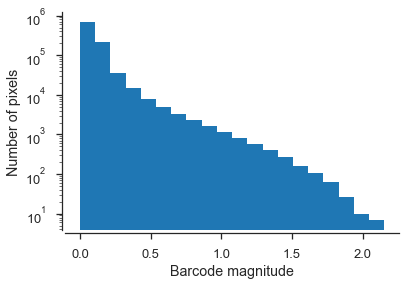

In [8]:
def compute_magnitudes(stack, norm_order=2):

    pixel_intensities = IntensityTable.from_image_stack(zero_norm_stack)
    feature_traces = pixel_intensities.stack(traces=(Indices.CH.value, Indices.ROUND.value))
    norm = np.linalg.norm(feature_traces.values, ord=norm_order, axis=1)

    return norm

mags = compute_magnitudes(zero_norm_stack)

plt.hist(mags, bins=20);
sns.despine(offset=3)
plt.xlabel('Barcode magnitude')
plt.ylabel('Number of pixels')
plt.yscale('log');

### Decode

In [33]:
# how much magnitude should a barcode have for it to be considered by decoding? this was set by looking at
# the plot above
magnitude_threshold = 0.5
# how big do we expect our spots to me, min/max size. this was set to be equivalent to the parameters
# determined by the Zhang lab.
area_threshold = (5, 30)
# how close, in euclidean space, should the pixel barcode be to the nearest barcode it was called to?
# here, I set this to be a large number, so I can inspect the distribution of decoded distances below
distance_threshold = 3

psd = SpotFinder.PixelSpotDetector(
    codebook=exp.codebook,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

spot_intensities, results = psd.run(zero_norm_stack)
spots_df = spot_intensities.to_features_dataframe()
spots_df['area'] = np.pi*spots_df['radius']**2
spots_df.head()

100%|██████████| 500140/500140 [00:00<00:00, 1836939.69it/s]


PicklingError: Can't pickle <function CombineAdjacentFeatures._single_spot_attributes at 0x131015ea0>: it's not the same object as starfish.spots._detector.combine_adjacent_features.CombineAdjacentFeatures._single_spot_attributes

### QC Plots

#### parameter tuning plots

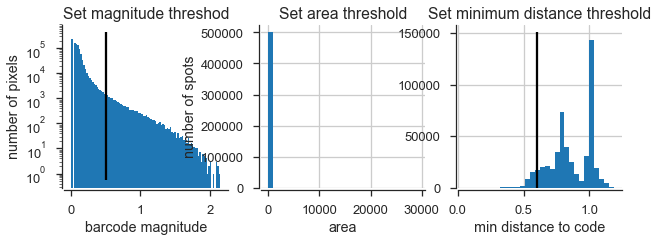

In [10]:
# these plots help inform how the parameters above were wet.
# looking at the last plot below, I reset the distance_threshold parameter to
min_dist = 0.6

plt.figure(figsize=(10,3))

plt.subplot(131)
plt.hist(mags, bins=100);
plt.yscale('log')
plt.xlabel('barcode magnitude')
plt.ylabel('number of pixels')
sns.despine(offset=2)
plt.vlines(magnitude_threshold, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])
plt.title('Set magnitude threshod')

plt.subplot(132)
spots_df['area'] = np.pi*spots_df.radius**2
spots_df.area.hist(bins=30);
plt.xlabel('area')
plt.ylabel('number of spots')
sns.despine(offset=2)
plt.title('Set area threshold')

plt.subplot(133)
spots_df.distance.hist(bins=30)
plt.xlabel('min distance to code');
plt.vlines(min_dist, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])
sns.despine(offset=2)
plt.title('Set minimum distance threshold');

#### Copy number comparisons

In [11]:
# select spots with distance less than a threshold, and count the number of each target gene
cnts_starfish = spots_df[spots_df.distance<=min_dist].groupby('target').count()['area']
cnts_starfish = cnts_starfish.reset_index(level=0)
cnts_starfish.rename(columns = {'target':'gene', 'area':'cnt_starfish'}, inplace=True)

benchmark_comparison = pd.merge(cnts_benchmark, cnts_starfish, on='gene', how='left')
benchmark_comparison.head(20)

,gene,cnt,cnt_starfish
0,MYH11,29,148.0
1,RELN,22,35.0
2,NR4A2,20,179.0
3,COL20A1,14,1443.0
4,IGFBP5,13,93.0
5,JAG1,12,41.0
6,ADCY8,12,2263.0
7,ANKRD13A,10,2629.0
8,INPP5D,9,1934.0
9,MBP,8,31.0


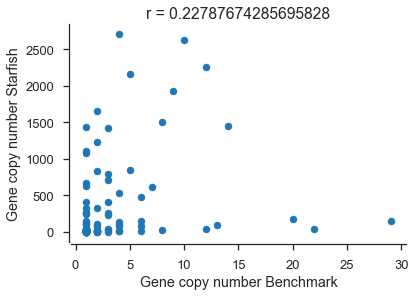

In [12]:
x = benchmark_comparison.dropna().cnt.values
y = benchmark_comparison.dropna().cnt_starfish.values
r = np.corrcoef(x, y)
r = r[0,1]

plt.scatter(x, y, 50,zorder=2)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.title('r = {}'.format(r))

sns.despine(offset=2)

#### visualization of rolonies

In [13]:
distance_threshold = min_dist

psd = SpotFinder.PixelSpotDetector(
    codebook=exp.codebook,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

spot_intensities, results = psd.run(zero_norm_stack)

In [27]:
np.unique(spot_intensities['passes_filters'], return_counts=True)

(array([0, 1]), array([480485,  19655]))

In [30]:
passes_filters = spot_intensities.where(spot_intensities['passes_filters'], drop=True)

In [31]:
counts = pd.Series(*np.unique(passes_filters['target'], return_counts=True)[::-1]).sort_values(ascending=False)

In [32]:
counts

RELN        5337
IGFBP5      5141
MN1         1552
NR4A2        902
MYH11        707
ADCY8        618
ANKRD13A     517
INPP5D       464
JAG1         459
COL20A1      419
GLRA2        349
CTSS         302
FREM2        269
FREM1        178
CD83         165
PCP4         146
OLFML3       145
LRRC25       137
MOBP          87
RASAL3        83
MOG           75
OSM           74
ITGA8         70
ROBO2         69
GRAP          59
ASPA          59
RASSF3        56
MGAT5         51
SYNPR         51
PDGFRA        47
            ... 
OLFML2B       13
MAB21L1       13
KCNH7         11
HS3ST5        11
VAV3          10
VIPR2         10
PDLIM5        10
MCC           10
KIT           10
SLC6A1         9
CLMN           9
SFMBT2         8
P2RX5          8
TMEM63A        8
NTNG2          8
RRBP1          7
TESC           7
CAPN3          7
SYT6           7
PTPRU          6
CD37           6
PCSK5          6
PLP1           5
NLRP3          3
DYNC1I1        2
P2RY13         2
CLTCL1         1
ATP2C2        

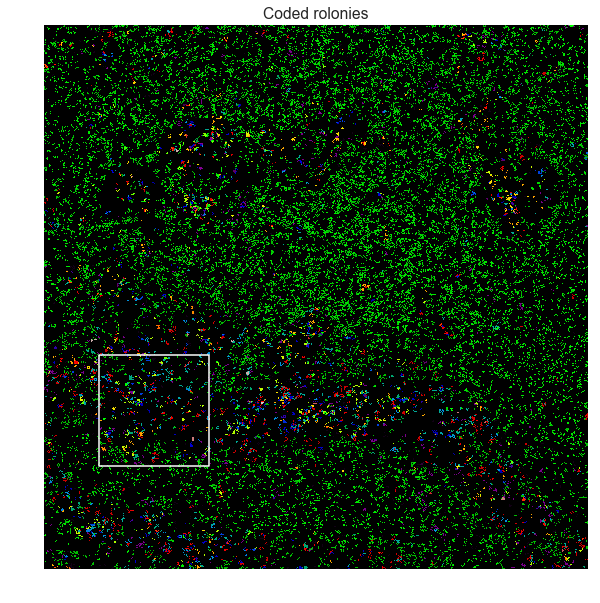

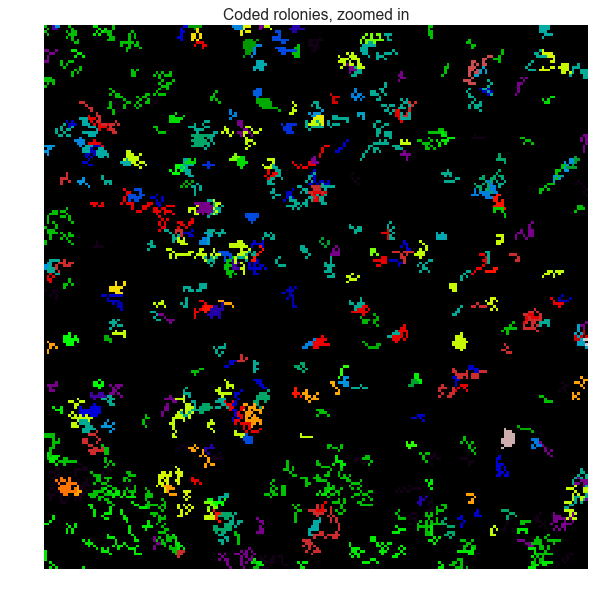

In [14]:
# exclude spots that don't meet our area thresholds
area_lookup = lambda x: 0 if x == 0 else results.region_properties[x - 1].area
vfunc = np.vectorize(area_lookup)
mask = np.squeeze(vfunc(results.label_image))
new_image = np.squeeze(results.decoded_image)*(mask > area_threshold[0])*(mask < area_threshold[1])

plt.figure(figsize=(10,10))
plt.imshow(new_image, cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies');

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

rect = [Rectangle((100, 600), width=200, height=200)]
pc = PatchCollection(rect, facecolor='none', alpha=1.0, edgecolor='w', linewidth=1.5)
plt.gca().add_collection(pc)

plt.figure(figsize=(10,10))
plt.imshow(new_image[600:800, 100:300], cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies, zoomed in');

### visualization of matched barcodes
here, we 1. pick a rolony that was succesfully decoded to a gene. 2. pull out the average pixel trace for that rolony and 3. plot that pixel trace against the barcode of that gene

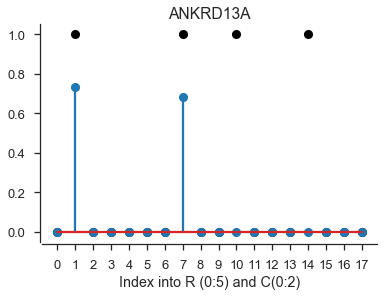

In [15]:
# reshape the spot intensity table into a RxC barcode vector
pixel_traces = spot_intensities.stack(traces=(Indices.ROUND.value, Indices.CH.value))

# extract dataframe from spot intensity table for indexing purposes
pixel_traces_df = pixel_traces.to_features_dataframe()
pixel_traces_df['area'] = np.pi*pixel_traces_df.radius**2

# pick index of a barcode that was read and decoded from the ImageStack
ind = 45

# get the the corresponding gene this barcode was decoded to
gene = pixel_traces_df.loc[ind].target

# query the codebook for the actual barcode corresponding to this gene
real_barcode = exp.codebook[exp.codebook.target==gene].stack(traces=(Indices.ROUND.value, Indices.CH.value)).values[0]
read_out_barcode = pixel_traces[ind,:]

plt.plot(real_barcode, 'ok')
plt.stem(read_out_barcode)
sns.despine(offset=2)
plt.xticks(range(18))
plt.title(gene)
plt.xlabel('Index into R (0:5) and C(0:2)');